In [1]:
import xtrack as xt
import xobjects as xo
import xpart as xp
import xcoll as xc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import apertls
import lossmaps as lm

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.


In [2]:
def get_k_ripple_summed_signal(num_turns, ripple_periods, kqf_amplitudes, kqd_amplitudes,
                                   kqf_phases, kqd_phases):
    """
    Generate noise signal on top of kqf/kqd values, with desired ripple periods and amplitudes.
    Phase and frequencies unit must correspond to where it is used, e.g turns
    
    Parameters:
    -----------
    ripple_periods : np.ndarray
        floats containing the ripple periods of the noise frequencies
    kqf_amplitudes : np.ndarray
        ripple amplitudes for desired frequencies of kqf --> obtained from normalized FFT spectrum of IQD and IQF. 
        Default without 50 Hz compensation is 1e-6
    kqd_amplitudes : list
        ripple amplitudes for desired frequencies of kqd --> obtained from normalized FFT spectrum of IQD and IQF. 
        Default without 50 Hz compensation is 1e-6
    kqf_phases : np.ndarray
        ripple phase for desired frequencies of kqf --> obtained from normalized FFT spectrum of IQD and IQF. 
    kqd_phases : list
        ripple phases for desired frequencies of kqd --> obtained from normalized FFT spectrum of IQD and IQF. 

    Returns:
    --------
    k_ripple_values : np.ndarray
        focusing quadrupole values corresponding to modulate Qx according to dq (if chosen plane)
    """

    turns = np.arange(1, num_turns+1)
    kqf_signals = np.zeros([len(ripple_periods), len(turns)])
    kqd_signals = np.zeros([len(ripple_periods), len(turns)])
    for i, ripple_period in enumerate(ripple_periods):
        kqf_signals[i, :] = kqf_amplitudes[i] * np.sin(2 * np.pi * turns / ripple_period + kqf_phases[i])
        kqd_signals[i, :] = kqd_amplitudes[i] * np.sin(2 * np.pi * turns / ripple_period + kqd_phases[i])

    # Sum the signal
    kqf_ripple = np.sum(kqf_signals, axis=0)
    kqd_ripple = np.sum(kqd_signals, axis=0)

    print('Generated kqf ripple of amplitudes {} and phases {} with ripple periods {}'.format(kqf_amplitudes, kqf_phases, ripple_periods))
    print('Generated kqd ripple of amplitudes {} and phases {} with ripple periods {}'.format(kqd_amplitudes, kqd_phases, ripple_periods))

    return kqf_ripple, kqd_ripple

In [3]:
line = xt.Line.from_json('../injection_lines/injection_thin_approx_ap_with_deferred_expressions.json')

#Set cavitiy voltages correctly
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180

line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180

#Add displacment of vertical dogleg in LSS5
line['qd.51710'].shift_y = -5.273e-3
line['qfa.51810'].shift_y = -17.369e-3
line['qd.51910'].shift_y = -5.273e-3

tab = line.get_table()
mask = [el.startswith('Limit') for el in tab.element_type]

for name in tab.name[mask]:
    if 'qd.51710' in name:
        line[name].shift_y = -5.273e-3
    elif 'qfa.51810' in name:
        line[name].shift_y = -17.369e-3
    elif 'qd.51910' in name:
        line[name].shift_y = -5.273e-3

tw = line.twiss()

Loading line from dict:   0%|          | 0/31362 [00:00<?, ?it/s]

Done loading line from dict.           


In [9]:
num_turns = 3000
num_particles = 1_000

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

plane = 'V'
amplitude_adt = 0.08
name_sim = 'tidvg_exact_pos'

In [5]:
# line.discard_tracker()
# coll = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
# line.collimators.install('tcsm.51932', coll)

In [6]:
def lin_eq_params(x1, y1, x2, y2):
    delta = x1-x2
    delta_a = y1-y2
    delta_b = x1*y2-x2*y1

    a = delta_a/delta
    b = delta_b/delta
    return a, b

def offset_colls_calc(a, b, s_rel):
    return a*s_rel + b

In [23]:
offset_upstream = -3.314e-3
offset_downstream = -2.152e-3

idx_tidvg = np.where(tw.name=='tidvg.51872')[0][0]
ap_tidvg_x = 78.6e-3/2
ap_tidvg_y = 40.8e-3/2

# sigma_tidvg_x, sigma_tidvg_y = np.sqrt(tw.betx[idx_tidvg]*nemitt_x/tw.gamma0), np.sqrt(tw.bety[idx_tidvg]*nemitt_y/tw.gamma0)
# gap_x, gap_y = ap_tidvg_x/sigma_tidvg_x, ap_tidvg_y/sigma_tidvg_y

a,b = lin_eq_params(0, offset_upstream, 4.3, offset_downstream)
jaw_RU_positions = [offset_colls_calc(a,b, 0), offset_colls_calc(a,b, 2.5), offset_colls_calc(a,b, 3.5), offset_colls_calc(a,b, 4.0)]
jaw_RD_positions = [offset_colls_calc(a,b, 2.5), offset_colls_calc(a,b, 3.5), offset_colls_calc(a,b, 4.0), offset_colls_calc(a,b, 4.3)]

tidvg_1 = xc.EverestCollimator(length=2.5, material = xc.materials.Carbon, jaw_RU = ap_tidvg_y + jaw_RU_positions[0], jaw_RD = ap_tidvg_y + jaw_RD_positions[0], angle = 90, side = 'right') #it is graphite but apparently that dos not exist (except Molybdenium graphite)
tidvg_2 = xc.EverestCollimator(length=1.0, material = xc.materials.Aluminium, jaw_RU = ap_tidvg_y + jaw_RU_positions[1], jaw_RD = ap_tidvg_y + jaw_RD_positions[1], angle = 90, side = 'right')
tidvg_3 = xc.EverestCollimator(length=0.5, material = xc.materials.Copper, jaw_RU = ap_tidvg_y + jaw_RU_positions[2], jaw_RD = ap_tidvg_y + jaw_RD_positions[2], angle = 90, side = 'right')
tidvg_4 = xc.EverestCollimator(length=0.3, material = xc.materials.Tungsten, jaw_RU = ap_tidvg_y + jaw_RU_positions[3], jaw_RD = ap_tidvg_y + jaw_RD_positions[3], angle = 90, side = 'right')

/Users/gebruiker/miniforge3/envs/xsuite2/lib/python3.13/site-packages/xcoll/beam_elements/base.py:502: RuntimeWarning: invalid value encountered in sqrt
  self._cos_yR = np.sqrt(1 - self._sin_yR**2)


In [ ]:
line.discard_tracker()
center_drift = 0.35
begin_tidvg = tw.s[idx_tidvg] + center_drift
coll_names = ['tidvg.51872..1_C', 'tidvg.51872..2_Al', 'tidvg.51872..3_Cu', 'tidvg.51872..4_W']
line.collimators.install(names=coll_names, elements=[tidvg_1, tidvg_2, tidvg_3, tidvg_4], at_s=[begin_tidvg, begin_tidvg+2.5, begin_tidvg+3.5, begin_tidvg+4])

factor=10 #To avoid having upper limit of collimatrthat does not exist. If 1, add the shift
coll_ap = xt.LimitRect(min_x = -ap_tidvg_x*factor, max_x=ap_tidvg_x*factor, min_y=-ap_tidvg_y*factor, max_y=ap_tidvg_y*factor) 
coll_ap_names = [suffix for name in coll_names for suffix in (f"{name}_aper_upstream", f"{name}_aper_downstream")]
coll_ap_idx = [idx for name in coll_names for idx in (line.element_names.index(name), line.element_names.index(name)+1)]

max_length = max(max(map(len, line.element_names)), max(map(len, coll_ap_names)))
element_names = np.array(line.element_names, dtype=f'<U{max_length}')
names = np.array(coll_ap_names, dtype=f'<U{max_length}')
element_names = np.insert(element_names, coll_ap_idx, coll_ap_names)

insert_colls = {name: coll_ap.copy() for name in coll_ap_names}

line.element_names = element_names.tolist()
line.element_dict = {**line.element_dict, **insert_colls}

# idx_upstream, idx_downstream = 0,0
# for name in coll_ap_names:
#     if 'upstream' in name:
#         #line[name].shift_y = jaw_RU_positions[idx_upstream]
#         line[name].min_y += jaw_RU_positions[idx_upstream]
#         line[name].max_y *= jaw_RU_positions[idx_upstream] # * to avoid upper jaw that does not exist
#         idx_upstream += 1
#     elif 'downstream' in name:
#         line[name].min_y += jaw_RD_positions[idx_downstream]
#         line[name].max_y *= jaw_RD_positions[idx_downstream] # * to avoid upper jaw that does not exist
#         idx_downstream += 1
#     else:
#         print(f'ERROR: no shift assigned to this aperture ({name})')

<class 'xcoll.beam_elements.everest.EverestCollimator'>
<class 'xcoll.beam_elements.everest.EverestCollimator'>
<class 'xcoll.beam_elements.everest.EverestCollimator'>
<class 'xcoll.beam_elements.everest.EverestCollimator'>


Slicing line:   0%|          | 0/30212 [00:00<?, ?it/s]

In [ ]:
df_with_coll = line.check_aperture()
assert not np.any(df_with_coll.has_aperture_problem)
#line.discard_tracker()
adt = xc.BlowUp.install(line, name=f'adt_{plane}_blowup', at_s=line.get_s_position('adkcv.32171'), plane=plane, stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=True)

line.build_tracker()
tw= line.twiss()
line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)
#line.optimize_for_tracking()

In [10]:
# #Ripple information
# kqf_amplitudes = np.array([9.7892e-7])
# kqd_amplitudes = np.array([9.6865e-7])
# kqf_phases=np.array([0.5564486])
# kqd_phases=np.array([0.47329223])
# ripple_freqs=np.array([50.])

# # Create ripple in quadrupolar knobs, convert phases to turns
# turns_per_sec = 1/tw.T_rev0
# ripple_periods = (turns_per_sec/ripple_freqs).astype(int)  # number of turns particle makes during one ripple oscillation
# kqf_phases_turns = kqf_phases * turns_per_sec # convert time domain to turn domain, i.e. multiply with turns/sec
# kqd_phases_turns = kqd_phases * turns_per_sec # convert time domain to turn domain, i.e. multiply with turns/sec

# kqf_ripple, kqd_ripple = get_k_ripple_summed_signal(num_turns, ripple_periods, kqf_amplitudes, kqd_amplitudes, kqf_phases_turns, kqd_phases_turns)

# # Save initial values
# kqf0 = line.vars['kqf']._value
# kqd0 = line.vars['kqd']._value

# print('Quadrupolar knobs will oscillate with')
# print('kqf =  {:.4e} +/- {:.3e}'.format(kqf0, max(kqf_ripple)))
# print('kqd = {:.4e} +/- {:.3e}'.format(kqd0, max(kqd_ripple)))

In [13]:
#part = line['tcsm.51932'].generate_pencil(num_particles)
#part = line['tidvg.51872..1_C'].generate_pencil(num_particles)
part = xp.generate_matched_gaussian_bunch(num_particles=num_particles, total_intensity_particles=2.2e11, nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=0.224, line=line) #He does not like if quadrupoles are shifted/you cannot optimise the line

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.2333673225727757m.
... distance to target bunch length: -2.2400e-01
... distance to target bunch length: 4.5434e-03
... distance to target bunch length: 4.3407e-03
... distance to target bunch length: -6.6704e-03
... distance to target bunch length: 2.0239e-03
... distance to target bunch length: -5.7437e-04
... distance to target bunch length: 1.0846e-04
... distance to target bunch length: 4.8389e-06
... distance to target bunch length: -2.0931e-09
... distance to target bunch length: 9.6457e-08
--> Bunch length: 0.22399999790691383
--> Emittance: 0.3430902949682595


In [14]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
line.track(part, num_turns=num_turns, time=True, with_progress=1)
adt.deactivate()
line.scattering.disable()

# line.discard_tracker()
# line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

# # Track!
# line.scattering.enable()
# time = 0
# for turn in range(1, num_turns):
#     if turn%100 == 0:
#         print(f'Turn {turn}')
    
#     line.vars['kqf'] = kqf0 + kqf_ripple[turn-1]
#     line.vars['kqd'] = kqd0 + kqd_ripple[turn-1]
    
#     line.track(part, num_turns=1, time=True)
#     time += line.time_last_track

# print(f"Done tracking in {time:.1f}s.")
# line.scattering.disable()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/3000 [00:00<?, ?it/s]

In [15]:
np.unique(part.state, return_counts=True)

(array([0, 1]), array([711, 289]))

In [17]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu())

ThisLM = xc.LossMap(line, line_is_reversed=False, part=part)
ThisLM.to_json(file=f'LM_{name_sim}.json')

Performing the aperture losses refinement.


/Users/gebruiker/Xsuite/lossmaps/lossmaps/lossmap.py:860: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._losses = pd.concat([ coll_df, aper_df ], ignore_index=True)


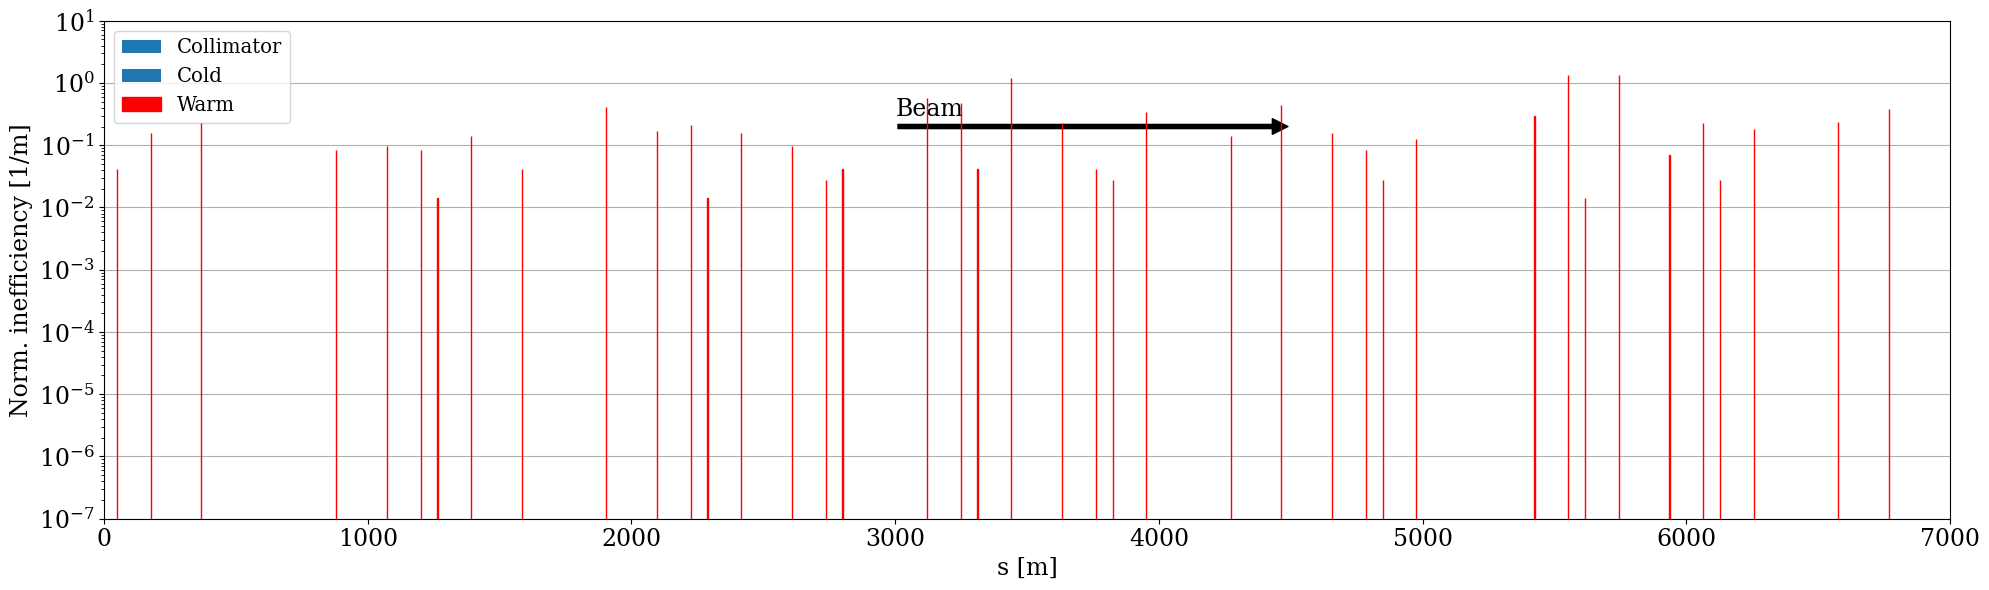

In [18]:
ThisLM = lm.SimulatedLossMap(lmtype=lm.LMType.B1H, machine=lm.Machine.SPS)
ThisLM.load_data_json(json_files=[f'LM_{name_sim}.json'])
fig = lm.plot_lossmap(ThisLM, xlim=(0,7000), show_zoom=False, ylim=[0.0000001,10], outfile=f'{name_sim}.png')
plt.show()

In [16]:
line_thick = xt.Line.from_json('../injection_lines/injection_thick_approx_ap.json')

Loading line from dict:   0%|          | 0/7477 [00:00<?, ?it/s]

Done loading line from dict.           


In [17]:
%matplotlib tk
plotter = apertls.InteractiveAperturePlotter(line, line_thick)

2025-03-26 14:54:52.349 python[3291:1131969] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-26 14:54:52.349 python[3291:1131969] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [26]:
exn=3.5e-6
tw=line.twiss()
tab = line.get_table()
mask = [el.startswith('Limit') for el in tab.element_type]
sigma_x = np.sqrt(tw.betx*exn/tw.gamma0)
sigma_x_restr = np.array([sigma_x[i] for i in range(len(sigma_x)) if mask[i]])
sigma_y = np.sqrt(tw.bety*exn/tw.gamma0)
sigma_y_restr = np.array([sigma_y[i] for i in range(len(sigma_y)) if mask[i]])

ap_s_x = np.array([[plotter.x_ext[i, 0]/sigma_x_restr[i], plotter.x_ext[i, 1]/sigma_x_restr[i]] for i in range(len(sigma_x_restr))])
ap_s_y = np.array([[plotter.y_ext[i, 0]/sigma_y_restr[i], plotter.y_ext[i, 1]/sigma_y_restr[i]] for i in range(len(sigma_y_restr))])

plotter2 = apertls.InteractiveAperturePlotter(line, line_thick, ap_x = ap_s_x, ap_y=ap_s_y)

In [19]:
np.min(ap_s_y[:,1])

np.float64(6.17073153617102)

In [25]:
idx_upstream, idx_downstream = 0,0
for name in coll_ap_names:
    if 'upstream' in name:
        #line[name].shift_y = jaw_RU_positions[idx_upstream]
        line[name].min_y += jaw_RU_positions[idx_upstream]
        line[name].max_y += jaw_RU_positions[idx_upstream]
        idx_upstream += 1
    elif 'downstream' in name:
        line[name].min_y += jaw_RD_positions[idx_downstream]
        line[name].max_y += jaw_RD_positions[idx_downstream]
        idx_downstream += 1
    else:
        print(f'ERROR: no shift assigned to this aperture ({name})')